### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Plotting helper function

In [2]:
def pretty_bar(data, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(15,12))
    sns.barplot(data.values, data.index)
    for i, v in enumerate(data.values):
        plt.text(0.8,i,v,color='k',fontsize=19)
    ylabel != None and plt.ylabel(ylabel, fontsize=12)
    xlabel != None and plt.xlabel(xlabel, fontsize=12)
    title != None and plt.title(title, fontsize=16)
    plt.show()

### Load data

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

train = pd.read_csv("../../data/shelter/train.csv", parse_dates=['DateTime'], date_parser=dateparse)
test  = pd.read_csv("../../data/shelter/test.csv", parse_dates=['DateTime'], date_parser=dateparse)

print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (26729, 10)
test shape: (11456, 8)


### First few rows of the train data

- I wonder why the name is included?  Is there anything we can do with it?  I don't think so, but missing names might indicate something (going off 5 data points, NaN is correlated with transfers)

- What use can I make out of OutcomeSubtype?  I wonder if the model would learn the subtypes easier, then I could map those to the OutcomeType

In [4]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### First few rows of the test data

In [5]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### Missing data

In [6]:
pd.DataFrame({
    "Train Missing": train.isnull().sum().astype(int),
    "Test Missing": test.isnull().sum().astype(int),
})

,Test Missing,Train Missing
AgeuponOutcome,6.0,18.0
AnimalID,NaN,0.0
AnimalType,0.0,0.0
Breed,0.0,0.0
Color,0.0,0.0
DateTime,0.0,0.0
ID,0.0,NaN
Name,3225.0,7691.0
OutcomeSubtype,NaN,13612.0
OutcomeType,NaN,0.0


### Is it possible to guess the Sex?

Not really, you can't guess a sex and whether a pet is neutered.  Since there's one missing value it doesn't make since to replace all NaN values with None.

I'm just going to drop this as an outlier

In [7]:
train[train.SexuponOutcome.isnull()]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
3174,A667395,Diego,2013-11-27 16:11:00,Return_to_owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle


In [8]:
train = train.drop(train[train.SexuponOutcome.isnull()].index)

### Merge train and test data

In [9]:
full = pd.concat([train, test])
train_N = len(train)

### Let's start off with the target column, 'OutcomeType'

Only 5 options are possible and it's very unlikely for the 'Died' outcome to happen

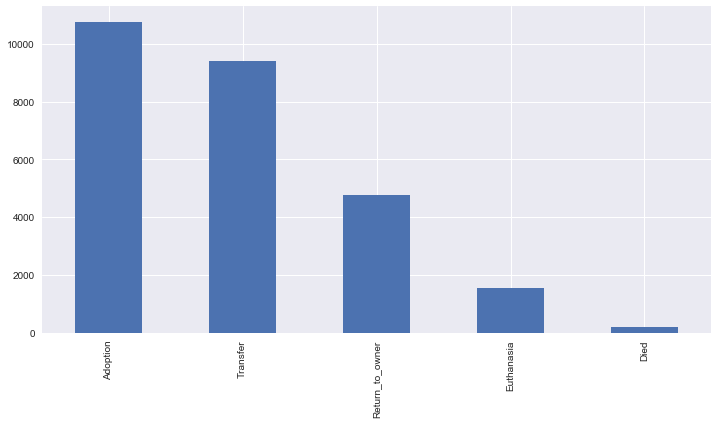

In [10]:
sns.set(rc={'figure.figsize':(12, 6)})

_ = train.OutcomeType.value_counts().plot(kind="bar")

### Create new column Outcome (OutcomeType + OutcomeSubtype)

In [11]:
train["Outcome"] = train.OutcomeType + " - " + train.OutcomeSubtype

print("Number of unique OutcomeSubtypes: ", len(train.OutcomeSubtype.unique()))
print("Number of unique Outcomes: ", len(train.Outcome.unique()))

Number of unique OutcomeSubtypes:  17
Number of unique Outcomes:  18


### Weird, I'd expect them to have the same number of unique values

Let's look at the two columns closer

After looking it's interesting to note that 'Barn' is an OutcomeSubtype for both 'Adoption' and 'Transfer', also there's no 'Return_to_owner'

In [12]:
# switched order so easier to compare
train["Outcome"] = train.OutcomeSubtype + " - " + train.OutcomeType

outcome_unique = train.Outcome.unique()
suboutcome_unique = train.OutcomeSubtype.unique()

for i in range(len(outcome_unique)):
    if i == len(suboutcome_unique):
        print("           ****", outcome_unique[i])
    else:
        print(suboutcome_unique[i], "****", outcome_unique[i])

nan **** nan
Suffering **** Suffering - Euthanasia
Foster **** Foster - Adoption
Partner **** Partner - Transfer
Offsite **** Offsite - Adoption
SCRP **** SCRP - Transfer
Aggressive **** Aggressive - Euthanasia
Behavior **** Behavior - Euthanasia
Rabies Risk **** Rabies Risk - Euthanasia
Medical **** Medical - Euthanasia
In Kennel **** In Kennel - Died
In Foster **** In Foster - Died
Barn **** Barn - Transfer
Court/Investigation **** Court/Investigation - Euthanasia
Enroute **** Enroute - Died
At Vet **** At Vet - Died
In Surgery **** In Surgery - Died
           **** Barn - Adoption


### Fill in missing values in OutcomeSubtypes

After the missing values are filled in, let's recreate the Column 'Outcome' again

In [13]:
train.OutcomeSubtype = train.OutcomeSubtype.fillna("NaN")
train["Outcome"] = train.OutcomeType + " - " + train.OutcomeSubtype

print("Number of unique OutcomeSubtypes: ", len(train.OutcomeSubtype.unique()))
print("Number of unique Outcomes: ", len(train.Outcome.unique()))

Number of unique OutcomeSubtypes:  17
Number of unique Outcomes:  22


### All the possible outcomes

Very interesting, remember how Barn is a subtype shared between 'Adoption' and 'Transfer'?  Well there is only one example for each!

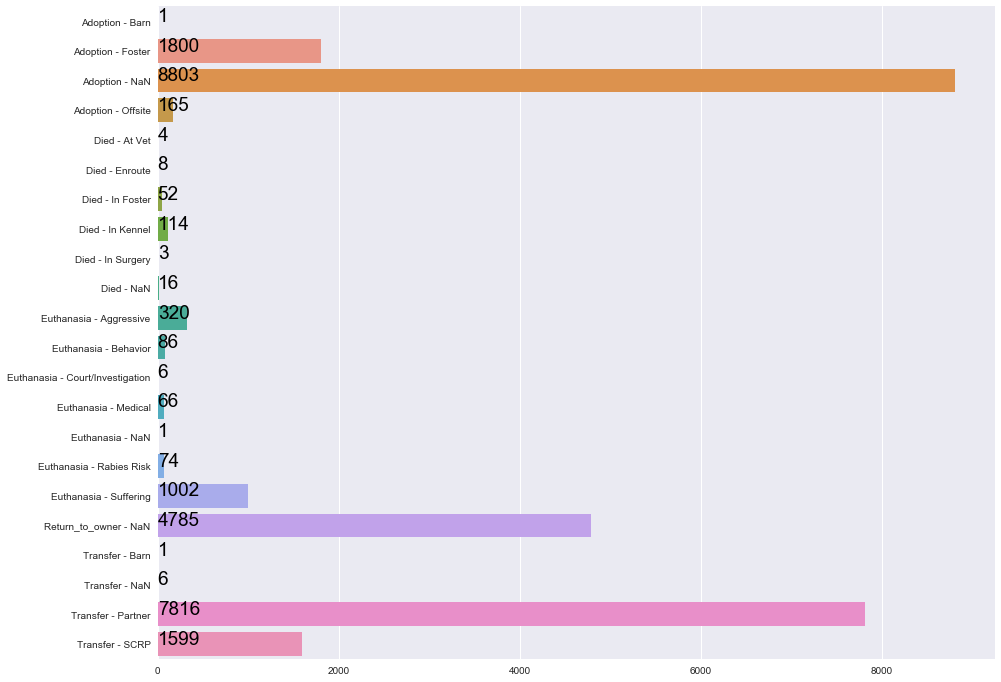

In [14]:
pretty_bar(train.Outcome.value_counts().sort_index())

### Difference animal types

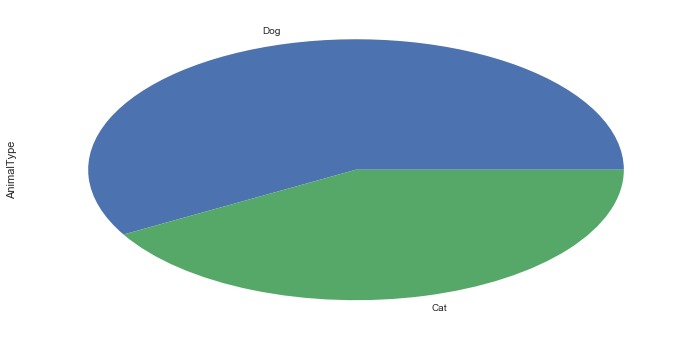

In [15]:
_ = full.AnimalType.value_counts().plot(kind="pie")

### SexuponOutcome

This column appears to have two pieces of information, the sex and whether the animal is neutered

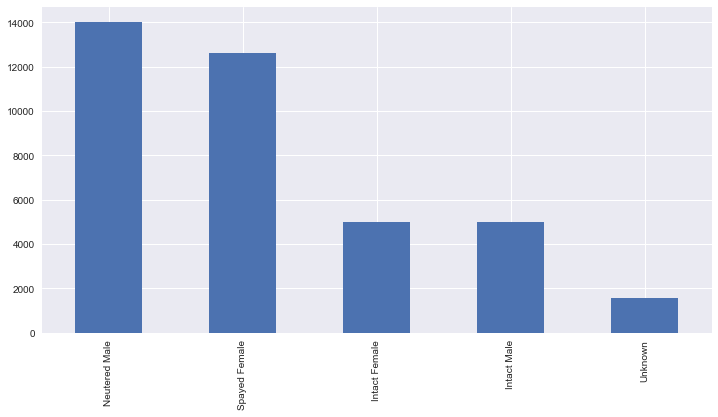

In [16]:
_ = full.SexuponOutcome.value_counts().plot(kind="bar")

### Create columns sex and is_netured

In [17]:
def get_neut(x):
    if x is np.nan:
        return np.nan
    elif x == "Unknown":
        return 2
    return int("Neutered" in x or "Sprayed" in x)

def get_sex(x):
    if x is np.nan:
        return np.nan
    elif x == "Unknown":
        return 2
    return int("Male" in x)

full["Sex"] = full.SexuponOutcome.map(get_sex)
full["isNetured"] = full.SexuponOutcome.map(get_neut)

full = full.drop(["SexuponOutcome"], axis=1)

### Sex and isNetured

Note:
        
    Sex       : 0 indicates "Female" , 1 indicates "Male",     2 indicates "Unknown"
    isNetured : 0 indicates "Natural", 1 indicates "Neutered", 2 indicates "Unknown"

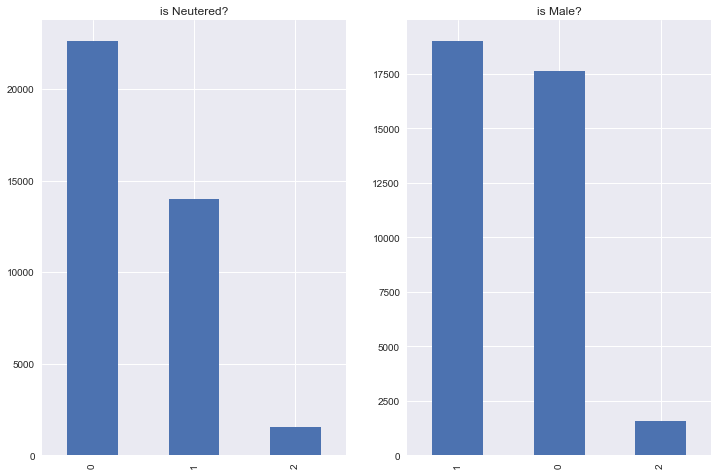

In [18]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 8))

full.isNetured.value_counts().plot(kind="bar", ax=axarr[0], title="is Neutered?")
_ = full.Sex.value_counts().plot(kind="bar", ax=axarr[1], title="is Male?")

### Breed and Color columns

In [19]:
print("All breeds contained in test data are in train data?")
print(set(test.Breed.unique()) <= set(train.Breed.unique()))
print()
print("All colors contained in test data are in train data?")
print(set(test.Color.unique()) <= set(train.Color.unique()))
print()
print("Num unique breeds", len(full.Breed.unique()))
print("Num unique colors", len(full.Color.unique()))

All breeds contained in test data are in train data?
False

All colors contained in test data are in train data?
False

Num unique breeds 1678
Num unique colors 411


### AgeuponOutcome

In [20]:
print(len(full.AgeuponOutcome.unique()))
print(full.AgeuponOutcome.unique())

46
['1 year' '2 years' '3 weeks' '1 month' '5 months' '4 years' '3 months'
 '2 weeks' '2 months' '10 months' '6 months' '5 years' '7 years' '3 years'
 '4 months' '12 years' '9 years' '6 years' '1 weeks' '11 years' '4 weeks'
 '7 months' '8 years' '11 months' '4 days' '9 months' '8 months' '15 years'
 '10 years' '1 week' '0 years' '14 years' '3 days' '6 days' '5 days'
 '5 weeks' '2 days' '16 years' '1 day' '13 years' nan '17 years' '18 years'
 '19 years' '20 years' '22 years']


In [21]:
def format_age(x):
    if x is np.nan:
        return None
    
    num, scale = x.split(" ")
    if scale in ["day", "days"]:
        return int(num)
    elif scale in ["week", "weeks"]:
        return 7 * int(num)
    elif scale in ["month", "months"]:
        return 30 * int(num)
    elif scale in ["year", "years"]:
        return 365 * int(num)
    else:
        print("scale", scale)
        raise Exception("Scale, {}, not contained".format(scale))

full.AgeuponOutcome = full.AgeuponOutcome.map(format_age)

### Fill in AgeuponOutcome values

In [22]:
full.AgeuponOutcome.fillna(
    full.groupby("Breed")["AgeuponOutcome"].transform("median"), inplace=True)

### AnimalType mapping

In [23]:
animal_map = {"Dog": 0, "Cat": 1}

full.AnimalType = full.AnimalType.map(animal_map)

### Breed mapping

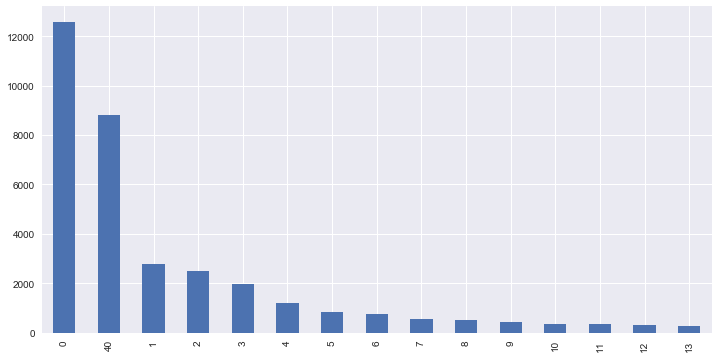

In [24]:
def get_col_map(df, col, cutoff):
    val_counts = df[col].value_counts()
    ret = dict()
    counter = 0
    
    for index in val_counts.index:
        count = val_counts[index]
        if count > cutoff:
            ret[index] = counter
            counter += 1
        else:
            ret[index] = counter
    return ret

breed_map = get_col_map(full, "Breed", 100)

full.Breed = full.Breed.map(breed_map)

_ = full.Breed.value_counts().head(15).plot(kind="bar")

### Color mapping

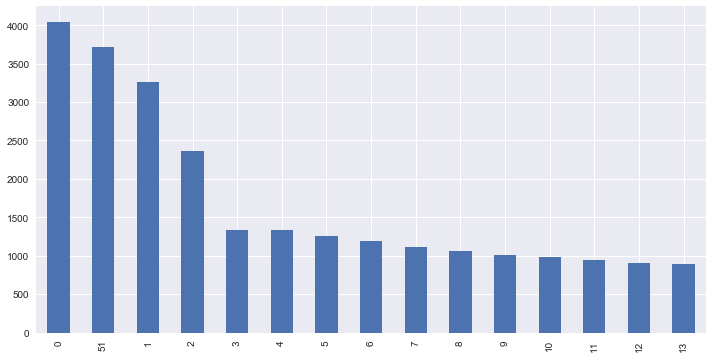

In [25]:
def get_col_map(df, col, cutoff):
    val_counts = df[col].value_counts()
    ret = dict()
    counter = 0
    
    for index in val_counts.index:
        count = val_counts[index]
        if count > cutoff:
            ret[index] = counter
            counter += 1
        else:
            ret[index] = counter
    return ret

color_map = get_col_map(full, "Color", 100)

full.Color = full.Color.map(color_map)

_ = full.Color.value_counts().head(15).plot(kind="bar")

### Split full back into train and test

In [27]:
train = full[:train_N]
test = full[train_N:]

### Quick prediction

In [28]:
train_y = train.OutcomeType
train_x = train.drop(["DateTime", "OutcomeType", "OutcomeSubtype", "Name", "AnimalID", "ID"], axis=1)

test_x = test.drop(["DateTime", "OutcomeType", "OutcomeSubtype", "Name", "AnimalID", "ID"], axis=1)

### Looking at the preprocessed data

In [29]:
train_x.head()

,AgeuponOutcome,AnimalType,Breed,Color,Sex,isNetured
0,365.0,0,40,5,1,1
1,365.0,1,0,30,0,0
2,730.0,0,1,9,1,1
3,21.0,1,0,51,1,0
4,730.0,0,40,12,1,1


In [30]:
test_x.head()

,AgeuponOutcome,AnimalType,Breed,Color,Sex,isNetured
0,300.0,0,3,25,0,0
1,730.0,0,40,10,0,0
2,365.0,1,0,2,1,1
3,120.0,0,40,8,1,0
4,730.0,0,10,3,1,1


## Construct the model

Let's try out a few models and see which works best through cross validation

In [39]:
# Different models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Cross validation imports
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold()

def score_model(model):
    score = cross_val_score(model, train_x, train_y, cv=k_fold, n_jobs=1, scoring="accuracy")
    print(score)
    print("\nAverage is ...")
    print(sum(score) / len(score))

### XGB (13.72084)

In [40]:
xgb_model = XGBClassifier()
xgb_model.fit(train_x, train_y)
score_model(xgb_model)

[ 0.59786756  0.59322034  0.59905713]

Average is ...
0.596715012251


### SVC (LB score: 15.44838)

In [41]:
svc_model = SVC()
svc_model.fit(train_x, train_y)
score_model(svc_model)

[ 0.53602694  0.53934224  0.53586261]

Average is ...
0.537077261685


### LGBM (LB score: 13.50678)

In [42]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(train_x, train_y)
score_model(lgbm_model)

[ 0.6037037   0.5987204   0.59625098]

Average is ...
0.599558360321


### Predictions

In [47]:
predictions = lgbm_model.predict(test_x)

### Save predictions to CSV

In [49]:
pd.DataFrame({
    "ID": test.ID.astype(int),
    "Adoption": [1 if pred == "Adoption" else 0 for pred in predictions],
    "Died": [1 if pred == "Died" else 0 for pred in predictions],
    "Euthanasia": [1 if pred == "Euthanasia" else 0 for pred in predictions],
    "Return_to_owner": [1 if pred == "Return_to_owner" else 0 for pred in predictions],
    "Transfer": [1 if pred == "Transfer" else 0 for pred in predictions]
}).to_csv('../../submissions/shelter_lgbm.csv',index=False)